In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno
import math
from statsmodels.stats import diagnostic
import statsmodels.stats as st
from scipy import stats
import networkx as nx
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier
# from sklearn.preprocessing import OneHotEncoder
# from pandas.plotting import scatter_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, auc, roc_curve

from director_scrap import director_scrap

%load_ext autoreload
%autoreload 2

In [2]:
# Metadata for 450,669 characters aligned to the movies above, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:

# 1. Wikipedia movie ID
# 2. Freebase movie ID
# 3. Movie release date
# 4. Character name
# 5. Actor date of birth
# 6. Actor gender
# 7. Actor height (in meters)
# 8. Actor ethnicity (Freebase ID)
# 9. Actor name
# 10. Actor age at movie release
# 11. Freebase character/actor map ID
# 12. Freebase character ID
# 13. Freebase actor ID

columns_char = ['Wiki_ID', 'Freebase_ID', 'Movie_release', 'Char_name', 'Actor_birth', 'Actor_gender', 
               'Actor_height', 'Actor_ethnicity', 'Actor_name', 'Actor_age_release', 'Char/Actor_map', 
               'Char_ID', 'Actor_ID']
df_char = pd.read_table('data/character.metadata.tsv', header=None, names=columns_char)
df_char.head(2)

,Wiki_ID,Freebase_ID,Movie_release,Char_name,Actor_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_release,Char/Actor_map,Char_ID,Actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4


In [3]:
# Metadata for 81,741 movies, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:

# 1. Wikipedia movie ID
# 2. Freebase movie ID
# 3. Movie name
# 4. Movie release date
# 5. Movie box office revenue
# 6. Movie runtime
# 7. Movie languages (Freebase ID:name tuples)
# 8. Movie countries (Freebase ID:name tuples)
# 9. Movie genres (Freebase ID:name tuples)

columns_mov = ['Wiki_ID', 'Freebase_ID', 'Movie_name', 'Movie_release', 'Movie_revenue', 'Movie_runtime', 
               'Movie_languages', 'Movie_countries', 'Movie_genres']
df_mov = pd.read_table('data/movie.metadata.tsv', header=None, names=columns_mov)
df_mov.head(2)

,Wiki_ID,Freebase_ID,Movie_name,Movie_release,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."


In [4]:
print(f"Movie : {len(df_mov)}      Actor : {len(df_char)}")

Movie : 81741      Actor : 450669


<AxesSubplot:>

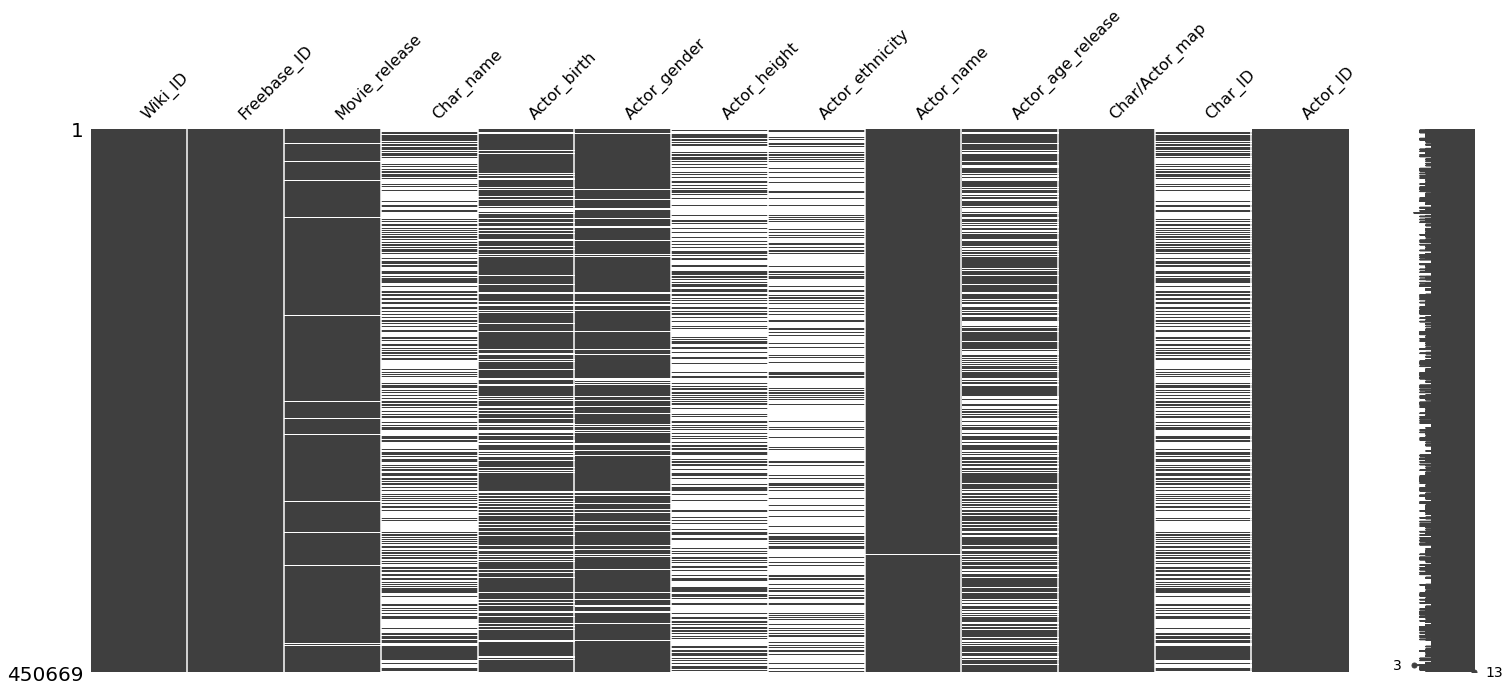

In [5]:
msno.matrix(df_char)

<AxesSubplot:>

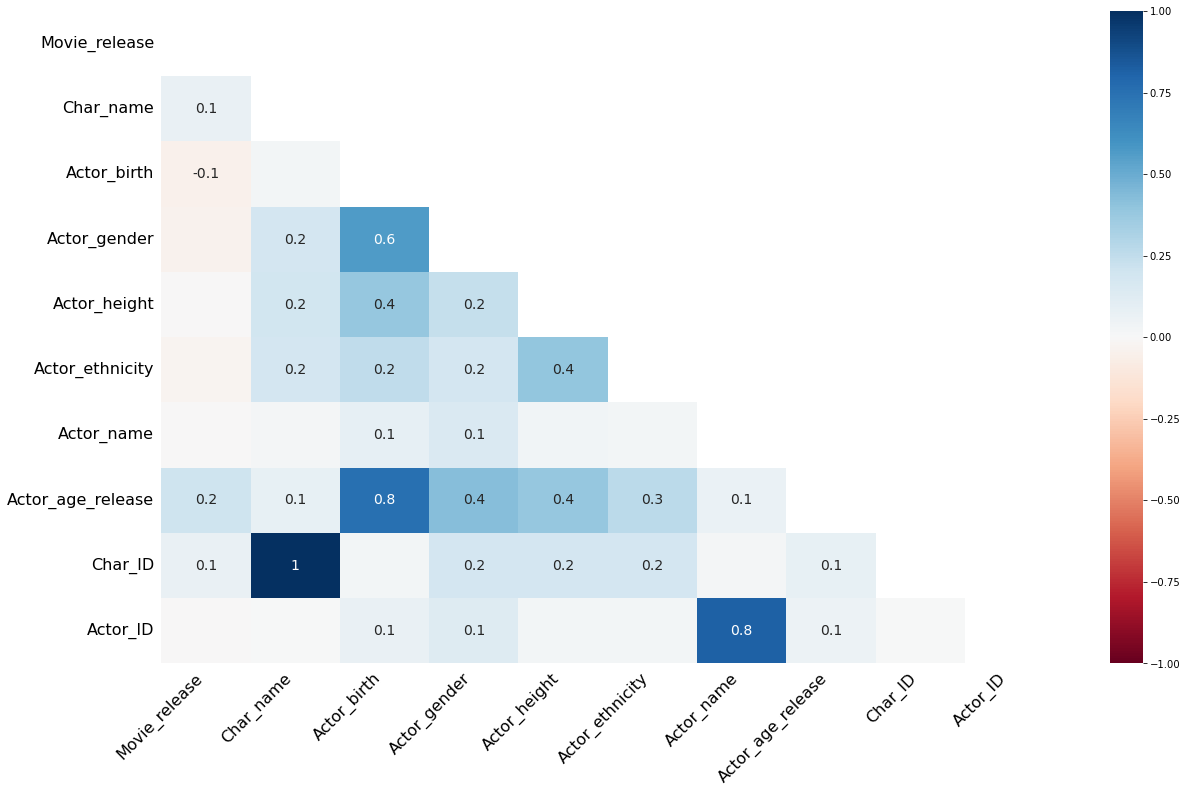

In [6]:
msno.heatmap(df_char)

<AxesSubplot:>

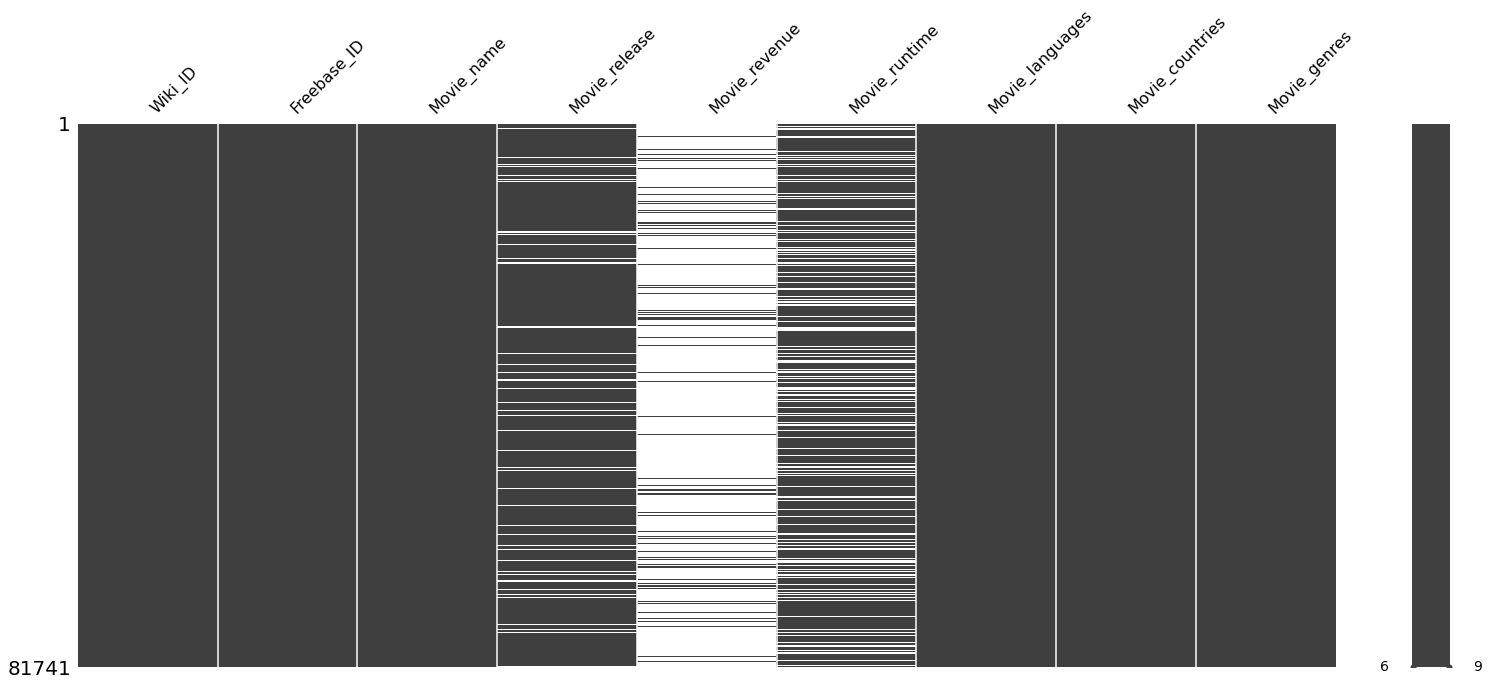

In [7]:
msno.matrix(df_mov)

<AxesSubplot:>

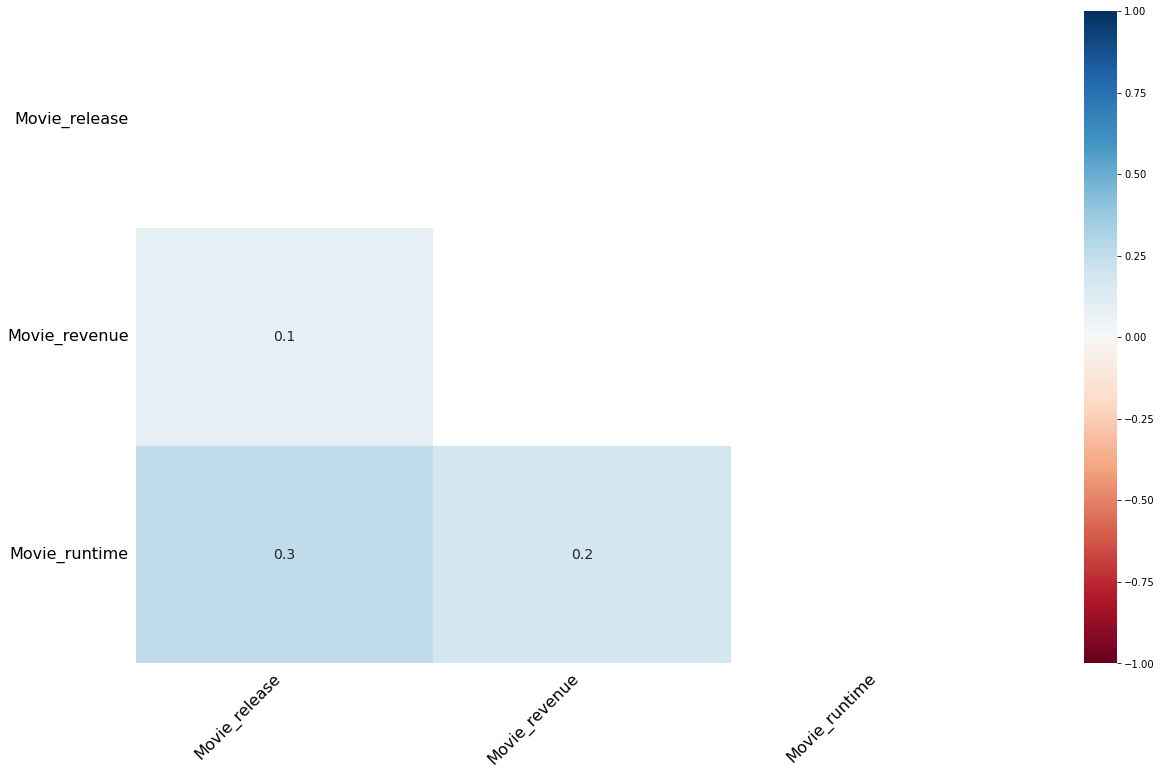

In [8]:
msno.heatmap(df_mov)

### When describing the relevant aspects of the data, and any other datasets you may intend to use, you should in particular show (non-exhaustive list):

**-That you can handle the data in its size.**

**-That you understand what’s in the data (formats, distributions, missing values, correlations, etc.).**

**-That you considered ways to enrich, filter, transform the data according to your needs.**

**-That you have a reasonable plan and ideas for methods you’re going to use, giving their essential mathematical details in the notebook.**

**-That your plan for analysis and communication is reasonable and sound, potentially discussing alternatives to your choices that you considered but dropped.**

In [9]:
df_mov_rel = df_mov.copy()
df_mov_rel['Movie_release'] = df_mov_rel['Movie_release'].apply(lambda x: float(str(x).split('-')[0]))

In [10]:
df_imdb = pd.read_table('data/imdb_dataV2.tsv')
df_imdb.head(1)

,imdb_rating,type,popular_title,original_title,movie_start_year,movie_end_year,runtime_min,genres,Producer,Composer,director,dir_birth,dir_death,dir_known_titles,writer,writer_birth,writer_death,writer_know_titles
0,5.7,short,Carmencita,Carmencita,1894.0,NaN,1.0,"Documentary,Short",NaN,NaN,William K.L. Dickson,1860.0,1935.0,"tt1428455,tt0219560,tt0308254,tt1496763",NaN,NaN,NaN,NaN


In [11]:
df_movie = df_mov_rel.merge(df_imdb, left_on=['Movie_release', 'Movie_name'], 
                            right_on=['movie_start_year', 'popular_title'], how='left')
df_movie.head(1)

,Wiki_ID,Freebase_ID,Movie_name,Movie_release,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,imdb_rating,...,Producer,Composer,director,dir_birth,dir_death,dir_known_titles,writer,writer_birth,writer_death,writer_know_titles
0,975900,/m/03vyhn,Ghosts of Mars,2001.0,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",4.9,...,Sandy King,Anthrax,John Carpenter,1948.0,NaN,"tt0080749,tt0077651,tt0069945,tt0082340",NaN,NaN,NaN,NaN


In [12]:
print(f"Samples in df_movie: {len(df_movie)}")
print(f"Columns of df_movie: {df_movie.columns}")

Samples in df_movie: 81741
Columns of df_movie: Index(['Wiki_ID', 'Freebase_ID', 'Movie_name', 'Movie_release',
       'Movie_revenue', 'Movie_runtime', 'Movie_languages', 'Movie_countries',
       'Movie_genres', 'imdb_rating', 'type', 'popular_title',
       'original_title', 'movie_start_year', 'movie_end_year', 'runtime_min',
       'genres', 'Producer', 'Composer', 'director', 'dir_birth', 'dir_death',
       'dir_known_titles', 'writer', 'writer_birth', 'writer_death',
       'writer_know_titles'],
      dtype='object')


In [13]:
df_movie = df_movie.drop(['type', 'popular_title', 'original_title', 'runtime_min'
                          , 'genres' , 'dir_birth', 'dir_death', 'dir_known_titles', 'writer_birth', 
                         'writer_death', 'writer_know_titles', 'movie_end_year'], axis=1)
df_movie.head(1)

,Wiki_ID,Freebase_ID,Movie_name,Movie_release,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,imdb_rating,movie_start_year,Producer,Composer,director,writer
0,975900,/m/03vyhn,Ghosts of Mars,2001.0,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",4.9,2001.0,Sandy King,Anthrax,John Carpenter,NaN


In [14]:
df_movie = df_movie.drop(['movie_start_year', 'Freebase_ID'], axis=1).rename(
    columns={'imdb_rating': 'Movie_rating', 'Producer': 'Movie_producer', 
             'Composer': 'Movie_composer', 'director': 'Movie_director',
            'writer': 'Movie_writer'})

# Below is the well processed and augmented movie database

In [15]:
df_movie.head(1)

,Wiki_ID,Movie_name,Movie_release,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Movie_rating,Movie_producer,Movie_composer,Movie_director,Movie_writer
0,975900,Ghosts of Mars,2001.0,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",4.9,Sandy King,Anthrax,John Carpenter,NaN


# Merge with actor database

In [16]:
df_all = df_movie.merge(df_char, on='Wiki_ID', how='right')
print(f"The database has {len(df_all)} entries")

The database has 450669 entries


In [17]:
df_all = df_all.drop(['Wiki_ID', 'Movie_release_y', 'Freebase_ID', 'Char/Actor_map', 'Char_ID', 
                      'Actor_ID'], axis=1).rename(columns={'Movie_release_x': 'Movie_release'})
df_all.head()

,Movie_name,Movie_release,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Movie_rating,Movie_producer,Movie_composer,Movie_director,Movie_writer,Char_name,Actor_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_release
0,Ghosts of Mars,2001.0,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",4.9,Sandy King,Anthrax,John Carpenter,NaN,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0
1,Ghosts of Mars,2001.0,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",4.9,Sandy King,Anthrax,John Carpenter,NaN,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0
2,Ghosts of Mars,2001.0,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",4.9,Sandy King,Anthrax,John Carpenter,NaN,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0
3,Ghosts of Mars,2001.0,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",4.9,Sandy King,Anthrax,John Carpenter,NaN,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0
4,Ghosts of Mars,2001.0,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",4.9,Sandy King,Anthrax,John Carpenter,NaN,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0


<AxesSubplot:>

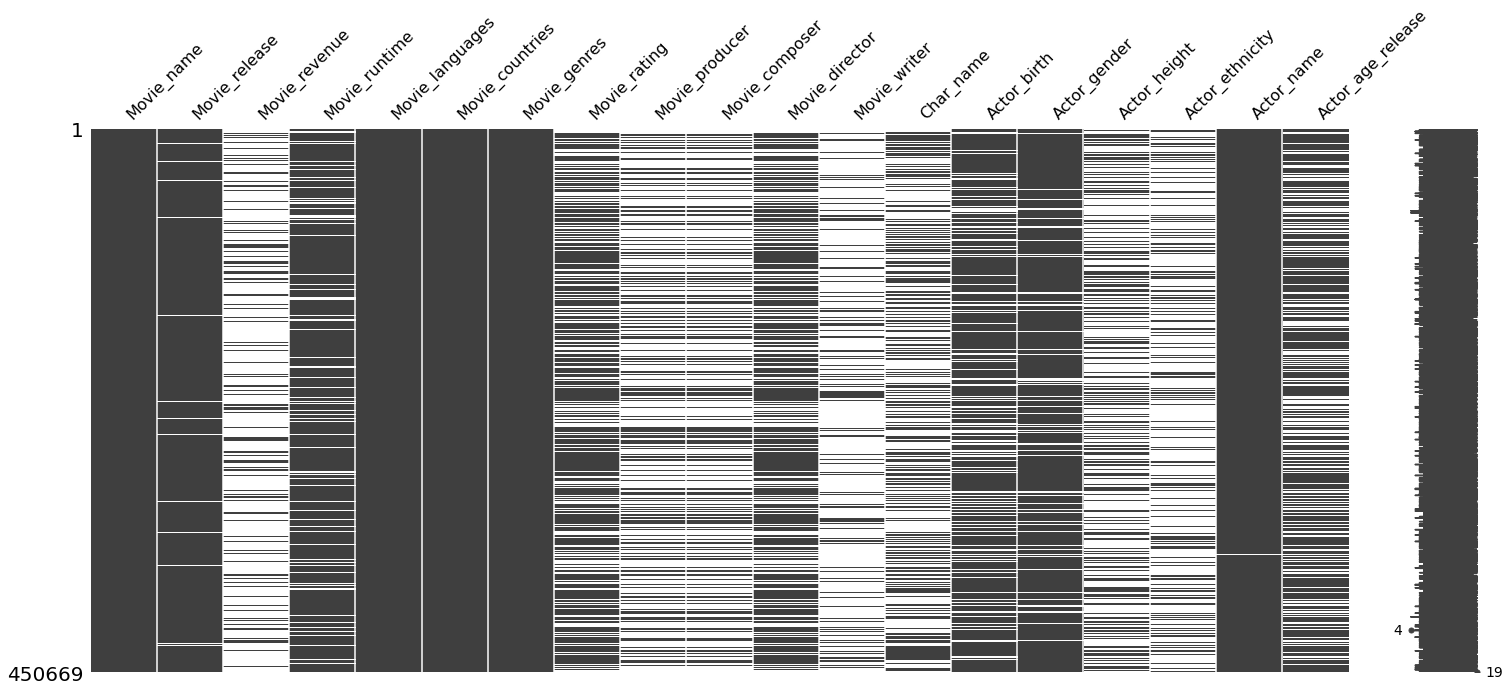

In [18]:
msno.matrix(df_all)

In [19]:
df = df_all.dropna(subset=['Movie_revenue'])
print(f"The database has now {len(df)} entries")

The database has now 101028 entries


<AxesSubplot:>

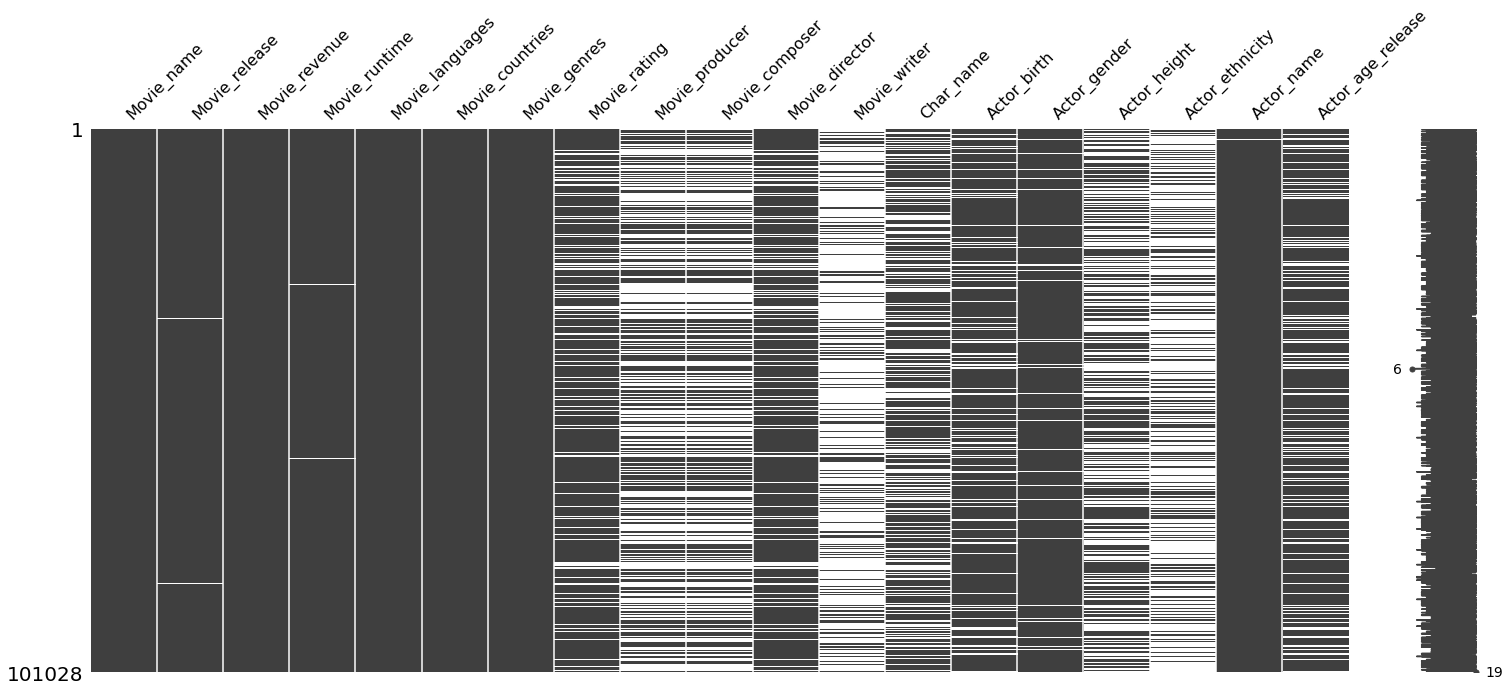

In [20]:
msno.matrix(df)

In [22]:
df_inflation = pd.read_csv('data/inflation_data.csv')

In [23]:
df_inflation.head()

,year,amount,inflation rate
0,1888,100.00,0.00
1,1889,96.84,-0.03
2,1890,95.79,-0.01
3,1891,95.79,0.00
4,1892,95.79,0.00


In [25]:
df_inflation.dtypes

year                int64
amount            float64
inflation rate    float64
dtype: object

In [26]:
df

,Movie_name,Movie_release,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Movie_rating,Movie_producer,Movie_composer,Movie_director,Movie_writer,Char_name,Actor_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_release
0,Ghosts of Mars,2001.0,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",4.9,Sandy King,Anthrax,John Carpenter,NaN,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0
1,Ghosts of Mars,2001.0,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",4.9,Sandy King,Anthrax,John Carpenter,NaN,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0
2,Ghosts of Mars,2001.0,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",4.9,Sandy King,Anthrax,John Carpenter,NaN,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0
3,Ghosts of Mars,2001.0,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",4.9,Sandy King,Anthrax,John Carpenter,NaN,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0
4,Ghosts of Mars,2001.0,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",4.9,Sandy King,Anthrax,John Carpenter,NaN,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450561,The Yellow Rolls-Royce,1964.0,5400000.0,122.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/07s9rl0"": ""Drama"", ""/m/03p5xs"": ""Comedy o...",6.4,Anatole de Grunwald,Riz Ortolani,Anthony Asquith,Terence Rattigan,Norwood,1900-08-31,M,NaN,NaN,Roland Culver,64.0
450562,The Yellow Rolls-Royce,1964.0,5400000.0,122.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/07s9rl0"": ""Drama"", ""/m/03p5xs"": ""Comedy o...",6.4,Anatole de Grunwald,Riz Ortolani,Anthony Asquith,Terence Rattigan,Harnsworth,1911-10-03,M,NaN,NaN,Michael Hordern,53.0
450563,The Yellow Rolls-Royce,1964.0,5400000.0,122.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/07s9rl0"": ""Drama"", ""/m/03p5xs"": ""Comedy o...",6.4,Anatole de Grunwald,Riz Ortolani,Anthony Asquith,Terence Rattigan,NaN,1908-11-02,M,NaN,NaN,Reginald Beckwith,56.0
450601,The Crucible,2011.0,30723856.0,NaN,"{""/m/02hwhyv"": ""Korean Language""}",{},"{""/m/07s9rl0"": ""Drama""}",NaN,NaN,NaN,NaN,NaN,NaN,1979-07-10,M,1.820,/m/01xhh5,Gong Yoo,32.0


In [29]:
from itertools import combinations

In [147]:
df_complete = pd.read_csv('data/df_movie.csv')
df_complete.rename(columns={'Movie_release_x': 'Movie_release'}, inplace=True)

In [166]:
df_complete.head()

,Movie_name,Movie_release,Movie_revenue,Movie_runtime,Movie_countries,Genre_dict,Main_genre,Sec_Genre,imdb_rating,runtime_min,...,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_release,Avg_revenue_per_film_at_release,Longevity,Number_of_film_at_release,Avg_rating_per_film_at_release,First_film
0,The Fox and the Hound,1981.0,63456988.0,83.0,"{""/m/09c7w0"": ""United States of America""}","{'/m/03k9fj': 'Adventure', '/m/0hj3myq': ""Chil...",Adventure,Children's/Family,NaN,NaN,...,NaN,NaN,NaN,'Squeeks' the Caterpillar,NaN,6.345699e+07,0.0,1,NaN,True
1,Miss March,2009.0,4591629.0,90.0,"{""/m/09c7w0"": ""United States of America""}","{'/m/04228s': 'Road movie', '/m/0gsy3b': 'Sex ...",Road movie,Sex comedy,NaN,NaN,...,M,NaN,NaN,40 Glocc,29.0,4.591629e+06,0.0,1,NaN,True
2,Get Rich or Die Tryin',2005.0,46442528.0,117.0,"{""/m/09c7w0"": ""United States of America""}","{'/m/0lsxr': 'Crime Fiction', '/m/026v1nw': 'H...",Crime Fiction,Hip hop movies,5.4,117.0,...,M,1.829,/m/0x67,50 Cent,30.0,4.644253e+07,0.0,1,5.400000,True
3,Home of the Brave,2006.0,499620.0,106.0,"{""/m/09c7w0"": ""United States of America"", ""/m/...","{'/m/07s9rl0': 'Drama', '/m/082gq': 'War film'}",Drama,War film,5.6,106.0,...,M,1.829,/m/0x67,50 Cent,31.0,2.347107e+07,1.0,2,5.500000,False
4,Righteous Kill,2008.0,76747202.0,100.0,"{""/m/09c7w0"": ""United States of America""}","{'/m/01jfsb': 'Thriller', '/m/0lsxr': 'Crime F...",Thriller,Crime Fiction,6.0,101.0,...,M,1.829,/m/0x67,50 Cent,33.0,4.122978e+07,3.0,3,5.666667,False


In [167]:
# Group by 'Movie_name' and aggregate 'Actor_name' into lists
actor_pairs = df_complete.groupby(['Movie_name', 'Movie_release'])['Actor_name'].apply(list)

# For each movie, create all possible pairs of actors without duplication
actor_pairs = actor_pairs.apply(lambda x: list(combinations(sorted(set(x)), 2)))

In [168]:
actor_pairs.head()

Movie_name               Movie_release
'Til There Was You       1997.0           [(Alice Drummond, Christine Ebersole), (Alice ...
(500) Days of Summer     2009.0           [(Chloë Moretz, Clark Gregg), (Chloë Moretz, G...
*batteries not included  1987.0           [(Dennis Boutsikaris, Doris Belack), (Dennis B...
...And Justice for All   1979.0           [(Al Pacino, Christine Lahti), (Al Pacino, Cra...
10                       1979.0           [(Bo Derek, Brian Dennehy), (Bo Derek, Dee Wal...
Name: Actor_name, dtype: object

In [169]:
df_pairs = pd.DataFrame(actor_pairs)
df_pairs = df_pairs.reset_index()
df_pairs = df_pairs.rename(columns={'Actor_name': 'Actor_pairs'})
df_pairs = df_pairs.explode('Actor_pairs')
df_pairs.head()

,Movie_name,Movie_release,Actor_pairs
0,'Til There Was You,1997.0,"(Alice Drummond, Christine Ebersole)"
0,'Til There Was You,1997.0,"(Alice Drummond, Craig Bierko)"
0,'Til There Was You,1997.0,"(Alice Drummond, Dylan McDermott)"
0,'Til There Was You,1997.0,"(Alice Drummond, Jeanne Tripplehorn)"
0,'Til There Was You,1997.0,"(Alice Drummond, Jennifer Aniston)"


In [170]:
df_pairs = df_pairs.merge(df_movie, on=['Movie_name', 'Movie_release'], how='left')

In [171]:
df_pairs.drop(['Wiki_ID', 'Movie_runtime', 'Movie_languages', 'Movie_countries', 'Movie_genres','Movie_producer','Movie_composer','Movie_director','Movie_writer'], axis=1, inplace=True)
df_pairs.dropna(subset=['Actor_pairs', 'Movie_release', 'Movie_revenue', 'Movie_rating'], inplace=True)

In [172]:
df_pairs['Actor1'] = df_pairs['Actor_pairs'].apply(lambda x: x[0])
df_pairs['Actor2'] = df_pairs['Actor_pairs'].apply(lambda x: x[1])
df_pairs.sort_values(by=['Movie_release'], inplace=True)

In [280]:
df_pairs.reset_index(drop=True, inplace=True)
df_pairs

,Movie_name,Movie_release,Actor_pairs,Movie_revenue,Movie_rating,Actor1,Actor2
0,The Million Dollar Mystery,1914.0,"(James Cruze, Sidney Bracey)",1500000.0,6.0,James Cruze,Sidney Bracey
1,The Million Dollar Mystery,1914.0,"(Marguerite Snow, Sidney Bracey)",1500000.0,6.0,Marguerite Snow,Sidney Bracey
2,The Million Dollar Mystery,1914.0,"(Lila Chester, Sidney Bracey)",1500000.0,6.0,Lila Chester,Sidney Bracey
3,The Million Dollar Mystery,1914.0,"(Lila Chester, Marguerite Snow)",1500000.0,6.0,Lila Chester,Marguerite Snow
4,The Million Dollar Mystery,1914.0,"(James Cruze, Marguerite Snow)",1500000.0,6.0,James Cruze,Marguerite Snow
...,...,...,...,...,...,...,...
552031,Hit and Run,2012.0,"(Dax Shepard, Jess Rowland)",14453354.0,9.4,Dax Shepard,Jess Rowland
552032,Hit and Run,2012.0,"(David Koechner, Tom Arnold)",14453354.0,9.4,David Koechner,Tom Arnold
552033,Hit and Run,2012.0,"(David Koechner, Steve Agee)",14453354.0,9.4,David Koechner,Steve Agee
552034,Hit and Run,2012.0,"(Beau Bridges, Jess Rowland)",14453354.0,9.4,Beau Bridges,Jess Rowland


In [264]:
df_complete.columns

Index(['Movie_name', 'Movie_release', 'Movie_revenue', 'Movie_runtime',
       'Movie_countries', 'Genre_dict', 'Main_genre', 'Sec_Genre',
       'imdb_rating', 'runtime_min', 'Producer', 'Composer', 'director',
       'writer', 'Freebase_ID', 'Char_name', 'Actor_birth', 'Actor_gender',
       'Actor_height', 'Actor_ethnicity', 'Actor_name', 'Actor_age_release',
       'Avg_revenue_per_film_at_release', 'Longevity',
       'Number_of_film_at_release', 'Avg_rating_per_film_at_release',
       'First_film'],
      dtype='object')

In [265]:
def query_info_for_actor_pairs(row, df, info):
    actor1 = row['Actor1']
    actor2 = row['Actor2']
    movie_name = row['Movie_name']
    movie_release = row['Movie_release']

    movie_condition = (df['Movie_name'] == movie_name) & (df['Movie_release'] == movie_release)

    info1 = df.loc[movie_condition & (df['Actor_name'] == actor1), info].values[0]
    info2 = df.loc[movie_condition & (df['Actor_name'] == actor2), info].values[0]

    return info1, info2

In [266]:
def age_difference_between_actors(row):
    age1, age2 = query_info_for_actor_pairs(row, df_complete, 'Actor_age_release')
    return abs(age1 - age2)

In [267]:
def film_count_difference_between_actors(row):
    film_count1, film_count2 = query_info_for_actor_pairs(row, df_complete, 'Number_of_film_at_release')
    
    return abs(film_count1 - film_count2)

In [268]:
def average_revenue_difference_at_release_between_actors(row):
    revenue1, revenue2 = query_info_for_actor_pairs(row, df_complete, 'Avg_revenue_per_film_at_release')
    
    return abs(revenue1 - revenue2)

In [269]:
def first_film_for_both(row):
    first_film1, first_film2 = query_info_for_actor_pairs(row, df_complete, 'First_film')

    return (first_film1 and first_film2)

In [331]:
def number_of_films_together(row, df):
    actor1 = row['Actor1']
    actor2 = row['Actor2']
    movie_name = row['Movie_name']
    movie_release = row['Movie_release']

    condition = (df['Movie_name'] == movie_name) & (df['Movie_release'] < movie_release) & (((df['Actor1'] == actor1) & (df['Actor2'] == actor2)) | ((df['Actor1'] == actor2) & (df['Actor2'] == actor1)))

    index = row.name
    if int((index / len(df)) * 100) % 10 == 0 and int(((index - 1) / len(df)) * 100) % 10 != 0:
        print(f"{int((index / len(df)) * 100)}%", end=' ')

    if index == 0:
        print("0%")

    return len(df.loc[condition]) / 2

In [337]:
number_of_films_together(df_pairs.iloc[55205], df_pairs)

0.0

In [338]:
test = df_pairs.apply(lambda x: number_of_films_together(x, df_pairs), axis=1)
test

0%


KeyboardInterrupt: 